## Base Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime as dt

import sys
sys.path.append("..")
from analysis.analysis_modules.load_data import LoadData
from analysis.analysis_modules.data_checks import BasicDataChecks
from analysis.analysis_modules.print_format import print_format
from analysis.analysis_modules.data_exploration import DataExploration

### Set Global Variables

In [2]:
PATH = "D:\\Code\\Projects\\5Swans\\storage\\trade"
CURRENCY = "AUD_SGD_XRP"
pair1, pair2, pair3 = "AUD_SGD", "XRP_AUD", "XRP_SGD"

### Load Data

In [3]:
# data_obj = LoadData(PATH, CURRENCY, pair1, pair2, pair3)
# data = data_obj.price_data

data_obj = BasicDataChecks("data_XRP.pkl")
data = data_obj.data

### Basic Data Checks

In [4]:
data_obj.check

----------------------------------------------------------------------------------------------------
Data head: 
                            AUD_SGD          XRP_AUD          XRP_SGD             trade          
                            bestBid  bestAsk bestBid bestAsk  bestBid bestAsk    trade0    trade1
2022-04-12 13:11:03.578656  1.01398   1.0141  0.9495  0.9505  0.95597  0.9611 -0.008229  0.001742
2022-04-12 13:11:06.754743  1.01398   1.0141  0.9495  0.9505  0.95597  0.9611 -0.008229  0.001742
2022-04-12 13:11:09.829060    1.014  1.01413  0.9495  0.9505  0.95597  0.9611 -0.008258  0.001762
2022-04-12 13:11:13.065116    1.014  1.01413  0.9495  0.9505  0.95597  0.9611 -0.008258  0.001762
2022-04-12 13:11:16.125246    1.014  1.01413  0.9495  0.9505  0.95597  0.9611 -0.008258  0.001762
----------------------------------------------------------------------------------------------------
Data tail:  
                            AUD_SGD          XRP_AUD         XRP_SGD              trade

### Timeframe

Each data point is taken at a unique second. 

In [5]:
hours = len(data)/(60*60)
print(print_format.BOLD + print_format.GREEN + "Hours of Data: " + print_format.END + f"{round(hours, 2)}")

Hours of Data: 6.99


---
## How Long Does the Arbitrage Opportunity Stay?

Clearly, there are repeated values. However, the timestamps are unique. It implies that an arbitrage opportunity exists for some period of time before vanishing. Let us analyse for how long does the arbitrage exist.

Let us do some data exploration. When you initialise the below object:
* Arbitrage time for each opportunity and the duration of it's existence will be calculated.
* Time differential between any given two data points will be calculated.

In [6]:
data_exp = DataExploration(data)

### Number of Times Arbitrage Opportunity Was Scanned

Percentage of Scanned Profitable Trades


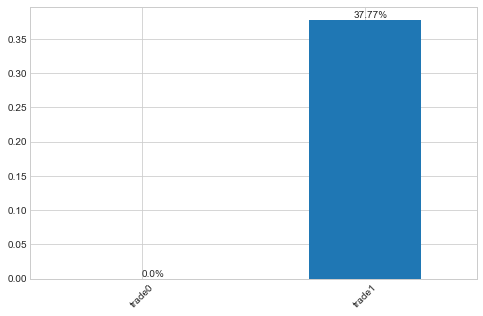

In [7]:
data_exp.count_arbitrage_opportunities(plot=True, ret=False)

<div class="alert alert-block alert-info">
From about 7 hours worth of data, arbitrage existed about <b>37.77%</b> of the time. However, this is an overestimation because the same arbitrage opportunity can exist for a length of time and it is being counted more than once.
</div>

### Unique Arbitrage Opportunities

Percentage of Unique Profitable Trades


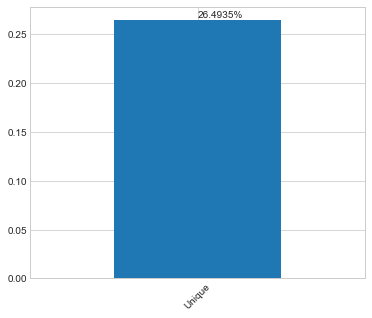

In [8]:
data_exp.unique_arb_opportunities(plot=True, ret=False)

<div class="alert alert-block alert-info">
As expected, the number of unique profitable trades happen only about <b>26.49%</b> of the times.
</div>

### Average Time for Which the Unique Arbitrage Lasts

**Calculate the Average Time for Unique Arbitrage Opportunities**<br>
The caveat with this is the bias wherein the frequency of arbitrage scanning is roughly 3.5 seconds. Therefore, any unique opportunity will be shown to last for atleast that much duration, affecting the average. <br><br>

In addition, it can suffer from slight underestimation of the arbitrage duration. For example:<br>
<b><i>At t0 =  0.0s:</i></b> Arbitrage Exists <br>
<b><i>At t1 =  3.5s:</i></b> Arbitrage Exists <br>
<b><i>At t2 =  7.0s:</i></b> Arbitrage Exists <br>
<b><i>At t3 = 10.5s:</i></b> Arbitrage Doesn't Exist <br>

The duration being taken into account is including `t0`, `t1` and `t2`. It might happen that the opportunity still exists between 7s and 10.5s. However, being conservative, the limit has been set to `t2`, beyond which the arbotrage ceases to exist.

<div class="alert alert-block alert-warning"><b>
Running the `average_arb_duration` method will filter for arb_durations:
</b></div>
<l>
<li>Less than or equal to 60 seconds by default
<li>Removes the unprofitable arbitrage simply because a calculation could reveal whether or not to take a trade, and naturally we would be inclined to take only a trade that has an expected profitability
<li>Returns only the unique trades
</l>

Duration Distribution of Profitable Arb. Opportunities


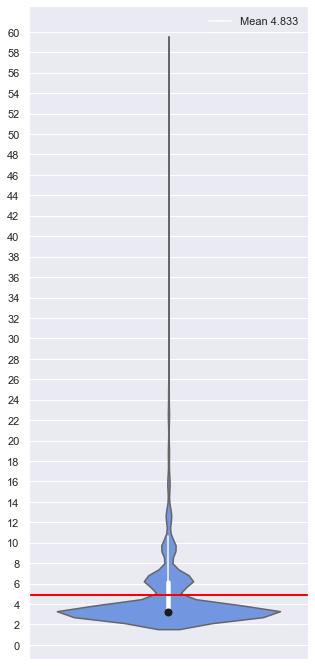

In [9]:
filtered_arb_dur = data_exp.average_arb_duration(filter_seconds=60, plot=True, ret = True)

<div class="alert alert-block alert-info"><b> Observations </b></div>
<li>On average, an positive arbitrage opportunity lasts about 4.8 seconds
<li>However, outliers are there, wherein an opportunity can even stretch to upto 58 seconds
<li>The maximum arbitrage opportunities last for slightly more than 3 seconds

### Returns Distribution

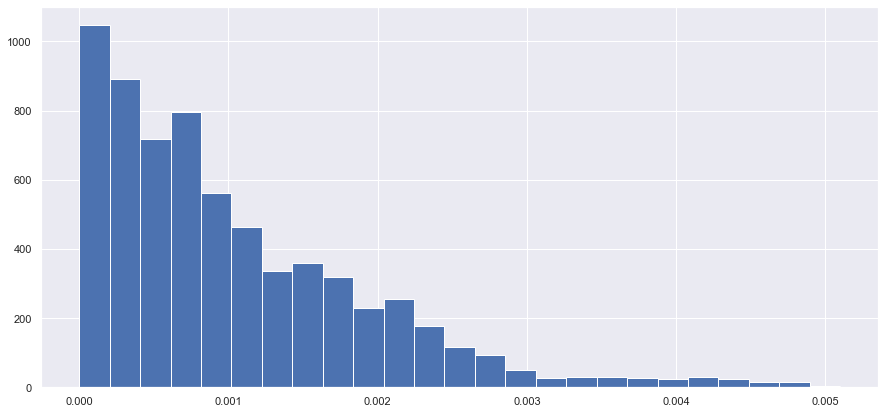

In [10]:
filtered_arb_dur["trade", "trade1"].hist(bins=25, figsize=(15, 7));

<div class="alert alert-block alert-info"><b> Observations </b></div>
<li>Majority of the returns lie within the 0.1% range. It would be interesting to see if these returns hold after commissions/fees/slippages.
<li>Right skewed outliers are definitely there. They might play a significant role in making the net arbitrage strategy profitable.

---
## Backtesting

### Transaction Route of Profitable Trade

Based on the analysis, the profitable triangular arbitrage path is:

| Conversion | Exchange | Deposit/Withdrawal | Trading Fees  |
|------------|----------|--------------------|---------------|
| AUD to SGD | Oanda    | Free               |Baked in spread|
| SGD to XRP | Ind. Res.| 0.15XRP W          |0.5%           |
| XRP to AUD | BTCMkts. | Free               |0.6%           |

**Links to Pages:**<br>
* [Oanda](https://www.oanda.com/bvi-en/cfds/our-pricing/)
* [Independent Reserve](https://www.independentreserve.com/help/fees)
* [BTC Markets](https://www.btcmarkets.net/fees)

### Mid-price, Spreads & Backtest Data

In [11]:
def calc_mid_price_and_spreads(data: pd.DataFrame):
    data = data.copy(deep=True)
    # Calculating the Mid-Prices & Spread
    data.insert(2, ("AUD_SGD", "midPrice"), data["AUD_SGD"].mean(axis=1), False)
    data.insert(3, ("AUD_SGD", "spread"), data["AUD_SGD"].diff(axis=1)["bestAsk"], False)

    data.insert(5, ("XRP_AUD", "midPrice"), data["XRP_AUD"].mean(axis=1), False)
    data.insert(7, ("XRP_AUD", "spread"), data["XRP_AUD"].diff(axis=1)["bestAsk"], False)

    data.insert(9, ("XRP_SGD", "midPrice"), data["XRP_SGD"].mean(axis=1), False)
    data.insert(11, ("XRP_SGD", "spread"), data["XRP_SGD"].diff(axis=1)["bestAsk"], False)
    return data

backtest_df = calc_mid_price_and_spreads(filtered_arb_dur)

### Return with Costs and Slippages

In [12]:
# Trade fees
ind_res_trade_fees = 0.005
btc_trade_fees = 0.006

# Deposit/Withdrawal Fees
xrp_withdrawal = 0.15
ind_res_W_fees = xrp_withdrawal/(1/backtest_df["XRP_SGD", "bestAsk"])

# Slippages
slippage = 0.005

### Helper Function

In [13]:
def plot_rets(backtest_df, data_len, ret = False, filter_ = False, filter_rets = 0.01):
    backtest_df = backtest_df.copy(deep=True)
    
    if filter_:
        backtest_df = backtest_df[backtest_df["trade", "trade1"] <= filter_rets]

    
    cum_rets = (1 + (backtest_df["trade", "trade1"] * (1 - ind_res_trade_fees) * (1 - btc_trade_fees) * (1 - slippage) * (1 - ind_res_W_fees))).cumprod()
    cum_rets.index = cum_rets.index.strftime('%Y-%m-%d %H:%M:%S/%f')
    
    # Return Variables
    total_rets = (cum_rets.iloc[-1] - 1)
    hourly_expected_returns = (cum_rets.iloc[-1] ** (3600/data_len))
    
    # Plot
    ax1 = cum_rets.plot(figsize=(12, 7), rot=45, title="Cumulative Returns")
    ax1.set_xticks([])
    ax1.set_xlabel("Time")
    ax1.set_ylabel("Cumulative Returns")
    
    backtest_df.index = backtest_df.index.strftime('%Y-%m-%d %H:%M:%S/%f')
    ax2 = backtest_df[[("AUD_SGD", "midPrice"), ("XRP_AUD", "midPrice"), ("XRP_SGD", "midPrice")]].plot(figsize=(12, 7), rot=45)
    ax2.set_xticks([])
    
    plt.show()
    
    # Printing return values
    print(print_format.BOLD + print_format.BLUE + "Total Return: " + print_format.END + str(round(total_rets, 2)) + "%")
    print(print_format.BOLD + print_format.BLUE + "Hourly Expected Return: " + print_format.END + str(round(hourly_expected_returns, 2)) + "%")
    
    if ret:
        return cum_rets

### Backtests

#### Cumulative Returns with All Type of Returns

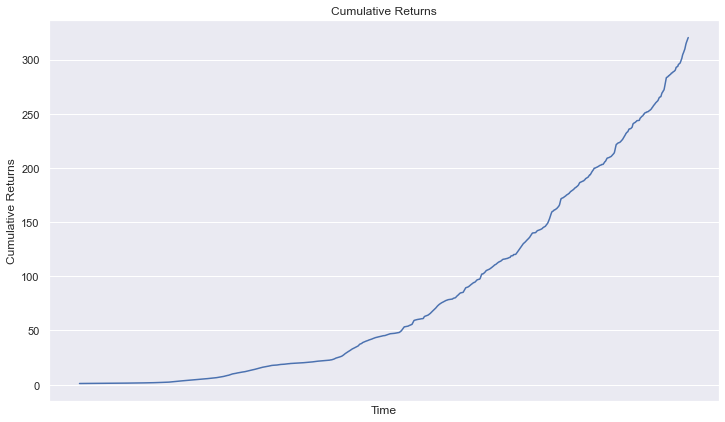

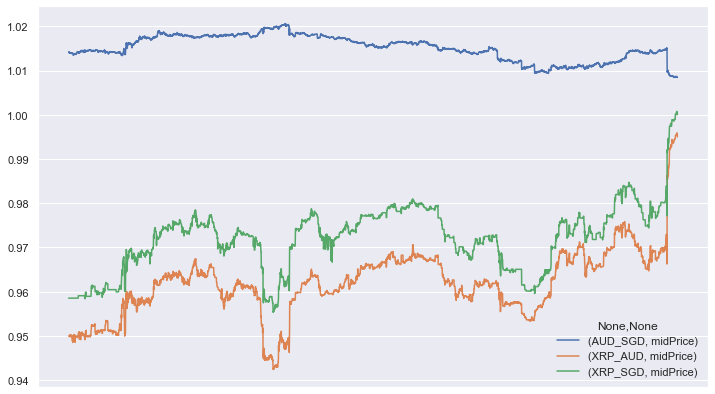

Total Return: 319.27%
Hourly Expected Return: 2.28%


In [14]:
plot_rets(backtest_df, data_len=len(data), ret=False)

#### Cumulative Returns Taking upto 0.2% as Max Returns

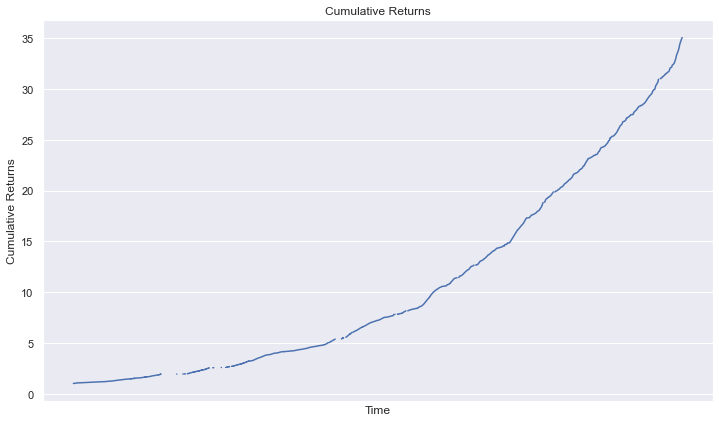

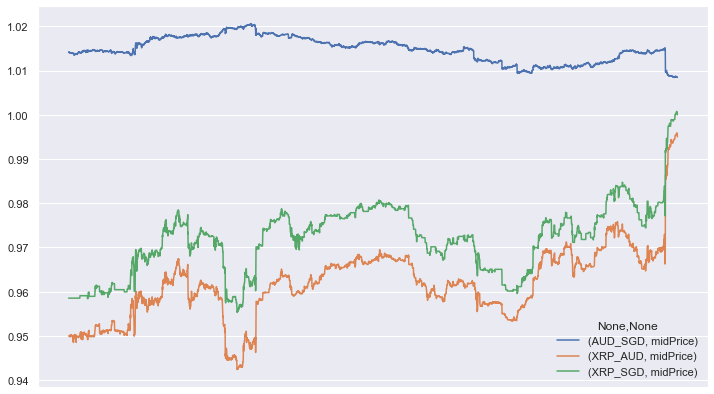

Total Return: 34.06%
Hourly Expected Return: 1.66%


In [15]:
plot_rets(backtest_df, data_len=len(data), ret=False, filter_=True, filter_rets=0.002)

#### Cumulative Returns Taking upto 0.1% as Max Returns

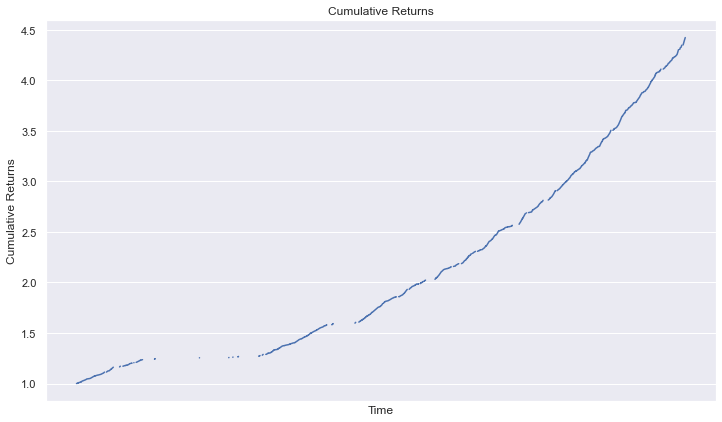

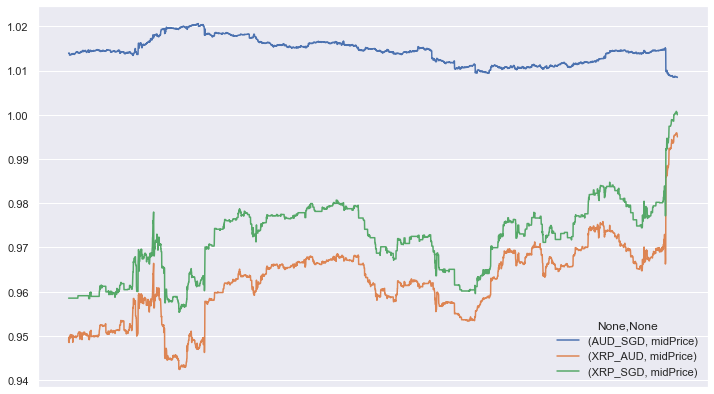

Total Return: 3.42%
Hourly Expected Return: 1.24%


In [16]:
plot_rets(backtest_df, data_len=len(data), ret=False, filter_=True, filter_rets=0.001)

---
## Conclusion
1. All three backtests, with costs and slippages, turn out to be profitable.
2. It clearly shows that arbitrage opportunity with good returns exists between the `AUD`, `SGD` and `XRP` pairs.
3. There is no point in including negative trades, simply because, the execution assumes a conditional check of a positive arbitrage opportunity existing. If the return is positive, only then the trade will be taken.
4. Slippages have been assumed to affect us negatively as a conservative approach. The reverse is possible as well, which could have a potentially significant impact.
5. With scale, the Trading Fees across different platforms reduces significantly. Oanda in particular has a commission based pricing, which can reduce the spread in our favour to a significant extent. BTCMarkets and Independent reserve, reduce fees as the 30-day AUD trading volume increases. Currently the assumption is of approximately AUD 100000 for charging a fees.

## Improvements
1. **Latency:** Reduce the latency to scan for more opportunities.
2. **Network:** 
    * **Disconnections**: A major roadblock I faced was frequent disconnections on my home network. Due to this, the data is not continuous. 
    * **REST APIs**: Using REST APIs instead of websockets, also slowed down the programme fixing the check to between 3.5 seconds. Plus, REST APIs are unreliable, and the data flow could stop without resuming for hours on end.
3. **Data Continuity:** <br> * -Had the data been continuous, an analysis of how the returns fluctuate with market volatility and rise/fall of individual currency pairs could have shed insight on ineeficiency in which pair gave higher chances of an arbitrage.* <br> * -However, a simple market watch still reveals that sudden changes in the `AUD_SGD` pair cause major inefficiencies.* <br> * -Attempting do this analysis currently was not possible, because, metrics like market volatility saw a huge jump because of discontinuous data.* <br> * -Assuming, data was continuos, a simple clustering algorithm would reveal some amazing insights into profitability related to market movements, verified with hypothesis testing.*